In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from mlxtend.plotting import plot_decision_regions
import matplotlib.pyplot as plt
import json
from DatasetObject import *
from CNNDataset import *

Using TensorFlow backend.


In [4]:
class DatasetInfo():
    def __init__(self):
        self.metadict = None
        self.load()
        
    def load(self): 
        with open("DatasetsMetaInfo.json", "r") as f:
            self.metadict = json.loads(f.read())        
        return self.metadict
    
    def update(self, dataset, lst_of_difficulty):
        self.metadict[dataset][2] = lst_of_difficulty
        
    def write(self):
        with open("DatasetsMetaInfo.json", "w") as f:
            f.write(json.dumps(self.metadict))
        
DI = DatasetInfo()     
print()

In [22]:
class DifficultyCalculation():
    threshold = 0.8
    epoch = 40
    bs = 20
    lr = 0.03
    
    def __init__(self, dataset_name):
        self.dataset = DatasetObject()
        self.dataset.loadDataset("", dataset_name)
        self.gau = True if dataset_name in ['bi_linear', 'multi_three', 'multi_four'] else False
        self.reg = True if dataset_name in ['reg_inform', 'reg_redun'] else False
        self.loss = 'binary_crossentropy' if dataset_name not in ['multi_three', 'multi_four', 'multi_circles'] else 'categorical_crossentropy'
        if self.dataset.isCNNData():
            self.loss = 'categorical_crossentropy' if self.dataset.getVariation() > 0 else 'binary_crossentropy'
        self.metric = 'accuracy' if not self.reg else 'mean_squared_error'
        if self.reg:
            self.loss = 'mean_squared_error'
        self.resultlst = []
        pass
    
    def createModelSet(self, input_size, output_size):
        model_lst = []
        init = tf.keras.initializers.GlorotUniform() 
        for i in range(5):
            inputs = tf.keras.Input(shape=input_size)    
            x = inputs
            if self.dataset.isCNNData():
                x = tf.keras.layers.Flatten()(x)
            if i ==0:
                x = tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_initializer=init)(x)
                outputs = tf.keras.layers.Dense(output_size, activation=tf.nn.relu)(x)
            if i ==1:
                x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
                outputs = tf.keras.layers.Dense(output_size, activation=tf.nn.tanh, kernel_initializer=init)(x)
            if i ==2:
                x = tf.keras.layers.Dense(8, activation=tf.nn.tanh, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(8, activation=tf.nn.tanh, kernel_initializer=init)(x)
                outputs = tf.keras.layers.Dense(output_size, activation=tf.nn.sigmoid, kernel_initializer=init)(x)
            if i ==3: 
                x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
                outputs = tf.keras.layers.Dense(output_size, activation=tf.nn.sigmoid, kernel_initializer=init)(x)
            if i ==4:
                x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
                x = tf.keras.layers.Dense(6, activation=tf.nn.relu, kernel_initializer=init)(x)
                outputs = tf.keras.layers.Dense(output_size, activation=tf.nn.sigmoid, kernel_initializer=init)(x)
            model = tf.keras.Model(inputs=inputs, outputs=outputs)
            model_lst.append(model)
        return model_lst    
    
    def calculate(self, verbose):
        for i in range(4):
            if verbose>0:
                print("Noise level:", i)
            acc_lst = []           
            n_rounds = 10 if not self.dataset.isCNNData() else 2
            for rounds in range(n_rounds):
                if verbose>0:
                    print("Round", rounds)
                
                if self.dataset.isCNNData():
                    self.dataset.doVariation(i)
                else:
                    self.dataset.addNoiseToData(i, self.gau, self.reg)      
                
                X_train = self.dataset.getTrainFeature()
                X_test = self.dataset.getTestFeature()
                classes = int(max(self.dataset.getTrainLabel()) +1)
                y_train = tf.keras.utils.to_categorical(self.dataset.getTrainLabel(), num_classes=classes)
                y_test = tf.keras.utils.to_categorical(self.dataset.getTestLabel(), num_classes=classes)
                
                model_lst = self.createModelSet(X_train.shape[1:], y_train.shape[1])
                for model in model_lst:
                    model.compile(loss=self.loss, 
                                  optimizer=tf.keras.optimizers.SGD(learning_rate=DifficultyCalculation.lr), 
                                  metrics=[self.metric])
                    epochs = DifficultyCalculation.epoch if not self.dataset.isCNNData() else 10
                    history = model.fit(X_train, y_train, 
                                        epochs=epochs, 
                                        batch_size=DifficultyCalculation.bs, verbose=0)
                    _, accuracy = model.evaluate(X_test, y_test, verbose=0)
                    
                    acc_lst.append(round(accuracy*100, 2))
                if verbose>1:
                    print("List of accuracy:", acc_lst[-5:])
            acc_lst = np.array(acc_lst)
            avg = (sum(acc_lst))/len(acc_lst)
            med = np.median(acc_lst)
            if verbose>0:
                print("Average accuracy:", avg)
                print("Median accuracy:", med)
                print("Difficulty:", len(acc_lst[acc_lst >= 80]))
            self.resultlst.append((avg, med))         
                    
    def getResultList(self):
        return self.resultlst

In [26]:
def train_and_write(datasetname):
    obj = DifficultyCalculation(datasetname) 
    obj.calculate(verbose=1)    
    print(obj.getResultList())
    return {dataset: obj.getResultList()}

def update_result_json(dict):
    try:
        with open("Training_result.json", "r") as f:
            res = json.loads(f.read())     
    except:
        res = {}
    res.update(dict)
    with open("Training_result.json", "w") as f:
        f.write(json.dumps(res))
    
def update_meta_info_json(DI):
    with open("Training_result.json", "r") as f:
        tmp_dict = json.loads(f.read())       

    for key,val in tmp_dict.items():
        if key not in ['reg_inform', 'reg_redun']:
            lst = [int(100-i[1]) for i in val]
        else:
            lst = [int(i) for i in np.sqrt([int(i[1]*100) for i in val])]
        DI.update(key, lst)
        print(key)
        print(lst)

    DI.write()

In [20]:
backups = ["Training_result_backup.json","Training_result2_backup.json","Training_result3_backup.json"]

for backup in backups:
    with open(backup, "r") as f:
        res = json.loads(f.read())    
        update_result_json(res)

In [ ]:
#This cell train and calculate the difficulty of all dataset

datasets = ['bi_linear', 'bi_moon', 'bi_circle', 'bi_xor', 'bi_spiral', 'multi_three', 'multi_four', 'multi_circles', 'reg_inform', 'reg_redun', 'cnn_mnist']

for dataset in datasets:
    update_result_json(train_and_write(dataset))

In [23]:
#This cell train and calculate the difficulty of a specific dataset

update_result_json(train_and_write("cnn_mnist"))

Noise level: 0
Round 0
Round 1
Average accuracy: 89.896
Median accuracy: 99.83
Difficulty: 8
Noise level: 1
Round 0
Round 1
Average accuracy: 93.72
Median accuracy: 94.59
Difficulty: 10
Noise level: 2
Round 0
Round 1
Average accuracy: 93.252
Median accuracy: 93.6
Difficulty: 10
Noise level: 3
Round 0
Round 1
Average accuracy: 86.095
Median accuracy: 91.125
Difficulty: 8
[(89.896, 99.83), (93.72, 94.59), (93.252, 93.6), (86.095, 91.125)]


In [27]:
#This cell update the meta info json file from the training result

update_meta_info_json(DI)

bi_linear
[0, 1, 9, 14]
bi_moon
[13, 14, 16, 17]
bi_circle
[22, 26, 30, 36]
bi_xor
[29, 24, 41, 43]
bi_spiral
[31, 31, 31, 32]
multi_three
[0, 1, 8, 19]
multi_four
[5, 17, 23, 41]
multi_circles
[63, 62, 62, 63]
reg_inform
[12, 9, 9, 11]
reg_redun
[12, 10, 16, 22]
cnn_mnist
[0, 5, 6, 8]


In [57]:
#            0 linear    1 moon     2 circle    3  xor      4  spiral   5 3-class       6  4-class    7  4 circles
datasets = ['bi_linear', 'bi_moon', 'bi_circle', 'bi_xor', 'bi_spiral', 'multi_three', 'multi_four', 'multi_circles']

    
def train_data(i):
    dataset = datasets[i]
    #print('============================{i}===================================='.format(i=i))
    df = pd.read_csv(dataset+'.csv')
    X = np.array(df[['x','y']])        
    y = np.array(df['label'])
    if i>=5:
        y = tf.keras.utils.to_categorical(y, num_classes=max(y)+1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
    
    def model_selection(i):    
        init = tf.keras.initializers.GlorotUniform()
        inputs = tf.keras.Input(shape=(X.shape[1],))    
        x = inputs
        outputs = tf.keras.layers.Dense(1, activation=tf.nn.relu, kernel_initializer=init)(x)
        if i > 0 and i <3:
            x = tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(5, activation=tf.nn.relu, kernel_initializer=init)(x)
            outputs = tf.keras.layers.Dense(1, activation=tf.nn.relu)(x)
        if i ==3:
            x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
            outputs = tf.keras.layers.Dense(1, activation=tf.nn.tanh, kernel_initializer=init)(x)
        if i ==4:
            x = tf.keras.layers.Dense(8, activation=tf.nn.tanh, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(8, activation=tf.nn.tanh, kernel_initializer=init)(x)
            outputs = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, kernel_initializer=init)(x)
        if i >4 and i <7: 
            x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(5, activation=tf.nn.tanh, kernel_initializer=init)(x)
            outputs = tf.keras.layers.Dense(y.shape[1], activation=tf.nn.sigmoid, kernel_initializer=init)(x)
        if i ==7:
            x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(7, activation=tf.nn.relu, kernel_initializer=init)(x)
            x = tf.keras.layers.Dense(6, activation=tf.nn.relu, kernel_initializer=init)(x)
            outputs = tf.keras.layers.Dense(y.shape[1], activation=tf.nn.sigmoid, kernel_initializer=init)(x)
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model
    
    #print(model.get_weights())      
    model = model_selection(i)
    if i<5:
        model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.03), metrics=['accuracy'])
    if i>=5:
        model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.SGD(learning_rate=0.03), metrics=['accuracy'])
    
    if 1:
        #print(model.get_weights())
        history = model.fit(X_train, y_train, epochs=40, batch_size=20, verbose=1)
        _, accuracy = model.evaluate(X_train, y_train, verbose=0)
        print('Train Accuracy: %.2f' % (accuracy*100))
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        print('Test Accuracy: %.2f' % (accuracy*100))
        #print(model.get_weights())

        plt.scatter(X_test[:,0], X_test[:,1])
        if i<5:
            plot_decision_regions(X_test, y_test.astype(np.integer), clf=model)
        else:
            class onehotmodel(object):
                def __init__(self, model):
                    self.model = model

                def predict(self, X):
                    y_pred = self.model(X)
                    return np.argmax(y_pred, axis=1)
            
            plot_decision_regions(X_test, np.argmax(y_test,axis=1), clf=onehotmodel(model))
            pass
        plt.show()

Train Accuracy: 99.37
Test Accuracy: 100.00


C:\Users\kit\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


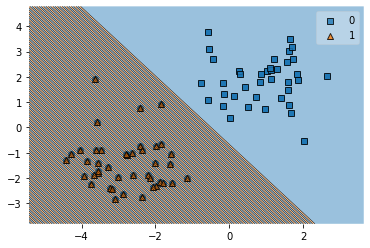

In [84]:
#            0 linear    1 moon     2 circle    3  xor      4  spiral   5 3-class       6  4-class    7  4 circles
datasets = ['bi_linear', 'bi_moon', 'bi_circle', 'bi_xor', 'bi_spiral', 'multi_three', 'multi_four', 'multi_circles']

train_data(0)

Train on 320 samples
Epoch 1/50
320/320 [==============================] - 0s 970us/sample - loss: 0.5949 - accuracy: 0.7250
Epoch 2/50
320/320 [==============================] - 0s 88us/sample - loss: 0.3685 - accuracy: 0.8344
Epoch 3/50
320/320 [==============================] - 0s 81us/sample - loss: 0.2911 - accuracy: 0.8500
Epoch 4/50
320/320 [==============================] - 0s 87us/sample - loss: 0.2611 - accuracy: 0.8687
Epoch 5/50
320/320 [==============================] - 0s 87us/sample - loss: 0.2442 - accuracy: 0.8656
Epoch 6/50
320/320 [==============================] - 0s 84us/sample - loss: 0.2407 - accuracy: 0.8719
Epoch 7/50
320/320 [==============================] - 0s 87us/sample - loss: 0.2323 - accuracy: 0.8813
Epoch 8/50
320/320 [==============================] - 0s 87us/sample - loss: 0.2266 - accuracy: 0.8750
Epoch 9/50
320/320 [==============================] - 0s 84us/sample - loss: 0.2238 - accuracy: 0.8844
Epoch 10/50
320/320 [==============================

C:\Users\kit\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


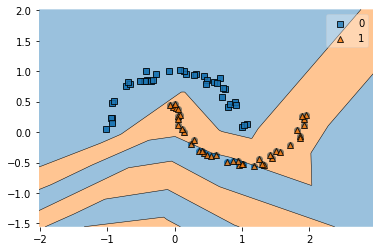

In [56]:
train_data(1)

Train on 320 samples
Epoch 1/40
320/320 [==============================] - 0s 980us/sample - loss: 1.1993 - accuracy: 0.4062
Epoch 2/40
320/320 [==============================] - 0s 93us/sample - loss: 0.7123 - accuracy: 0.4594
Epoch 3/40
320/320 [==============================] - 0s 92us/sample - loss: 0.6690 - accuracy: 0.5500
Epoch 4/40
320/320 [==============================] - 0s 89us/sample - loss: 0.6346 - accuracy: 0.6125
Epoch 5/40
320/320 [==============================] - 0s 93us/sample - loss: 0.5927 - accuracy: 0.6750
Epoch 6/40
320/320 [==============================] - 0s 90us/sample - loss: 0.5496 - accuracy: 0.7594
Epoch 7/40
320/320 [==============================] - 0s 90us/sample - loss: 0.5051 - accuracy: 0.8094
Epoch 8/40
320/320 [==============================] - 0s 82us/sample - loss: 0.4724 - accuracy: 0.8469
Epoch 9/40
320/320 [==============================] - 0s 87us/sample - loss: 0.4362 - accuracy: 0.8531
Epoch 10/40
320/320 [==============================

C:\Users\kit\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


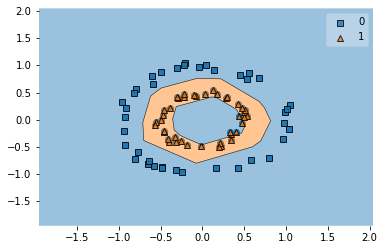

In [58]:
train_data(2)

Train on 320 samples
Epoch 1/40
320/320 [==============================] - 0s 967us/sample - loss: 0.8390 - accuracy: 0.4875
Epoch 2/40
320/320 [==============================] - 0s 83us/sample - loss: 0.6529 - accuracy: 0.6125
Epoch 3/40
320/320 [==============================] - 0s 90us/sample - loss: 0.6067 - accuracy: 0.6062
Epoch 4/40
320/320 [==============================] - 0s 86us/sample - loss: 0.5701 - accuracy: 0.7781
Epoch 5/40
320/320 [==============================] - 0s 84us/sample - loss: 0.5318 - accuracy: 0.8687
Epoch 6/40
320/320 [==============================] - 0s 84us/sample - loss: 0.4926 - accuracy: 0.9094
Epoch 7/40
320/320 [==============================] - 0s 84us/sample - loss: 0.4551 - accuracy: 0.9312
Epoch 8/40
320/320 [==============================] - 0s 81us/sample - loss: 0.4157 - accuracy: 0.9375
Epoch 9/40
320/320 [==============================] - 0s 84us/sample - loss: 0.3814 - accuracy: 0.9469
Epoch 10/40
320/320 [==============================

C:\Users\kit\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


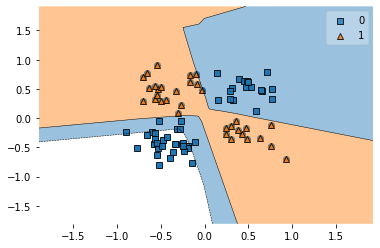

In [59]:
train_data(3)

Train on 640 samples
Epoch 1/40
640/640 [==============================] - 0s 509us/sample - loss: 0.7485 - accuracy: 0.5000
Epoch 2/40
640/640 [==============================] - 0s 85us/sample - loss: 0.6805 - accuracy: 0.5422
Epoch 3/40
640/640 [==============================] - 0s 80us/sample - loss: 0.6604 - accuracy: 0.6234
Epoch 4/40
640/640 [==============================] - 0s 79us/sample - loss: 0.6523 - accuracy: 0.6359
Epoch 5/40
640/640 [==============================] - 0s 78us/sample - loss: 0.6495 - accuracy: 0.6344
Epoch 6/40
640/640 [==============================] - 0s 83us/sample - loss: 0.6473 - accuracy: 0.6313
Epoch 7/40
640/640 [==============================] - 0s 77us/sample - loss: 0.6462 - accuracy: 0.6250
Epoch 8/40
640/640 [==============================] - 0s 78us/sample - loss: 0.6448 - accuracy: 0.6344
Epoch 9/40
640/640 [==============================] - 0s 79us/sample - loss: 0.6436 - accuracy: 0.6344
Epoch 10/40
640/640 [==============================

C:\Users\kit\Anaconda3\envs\nlp\lib\site-packages\ipykernel_launcher.py:65: DeprecationWarning: Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.


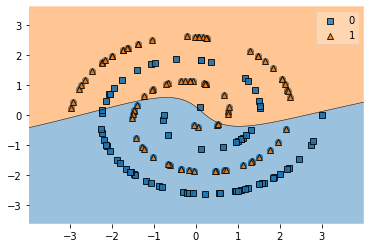

In [62]:
train_data(4)

Train on 480 samples
Epoch 1/40
480/480 [==============================] - 0s 734us/sample - loss: 1.2154 - accuracy: 0.0312
Epoch 2/40
480/480 [==============================] - 0s 94us/sample - loss: 1.0240 - accuracy: 0.5042
Epoch 3/40
480/480 [==============================] - 0s 90us/sample - loss: 0.8782 - accuracy: 0.7604
Epoch 4/40
480/480 [==============================] - 0s 87us/sample - loss: 0.7672 - accuracy: 0.8500
Epoch 5/40
480/480 [==============================] - 0s 85us/sample - loss: 0.6819 - accuracy: 0.9042
Epoch 6/40
480/480 [==============================] - 0s 83us/sample - loss: 0.6132 - accuracy: 0.9563
Epoch 7/40
480/480 [==============================] - 0s 85us/sample - loss: 0.5556 - accuracy: 0.9750
Epoch 8/40
480/480 [==============================] - 0s 85us/sample - loss: 0.5061 - accuracy: 0.9771
Epoch 9/40
480/480 [==============================] - 0s 85us/sample - loss: 0.4629 - accuracy: 0.9771
Epoch 10/40
480/480 [==============================

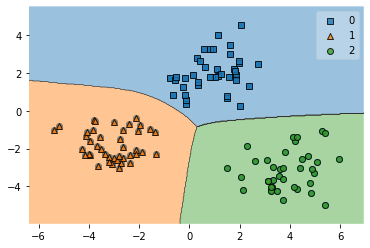

In [63]:
train_data(5)

Train on 480 samples
Epoch 1/40
480/480 [==============================] - 0s 732us/sample - loss: 1.3727 - accuracy: 0.3458
Epoch 2/40
480/480 [==============================] - 0s 91us/sample - loss: 1.3007 - accuracy: 0.5292
Epoch 3/40
480/480 [==============================] - 0s 90us/sample - loss: 1.2360 - accuracy: 0.5854
Epoch 4/40
480/480 [==============================] - 0s 89us/sample - loss: 1.1754 - accuracy: 0.6500
Epoch 5/40
480/480 [==============================] - 0s 85us/sample - loss: 1.1180 - accuracy: 0.7229
Epoch 6/40
480/480 [==============================] - 0s 83us/sample - loss: 1.0637 - accuracy: 0.7417
Epoch 7/40
480/480 [==============================] - 0s 87us/sample - loss: 1.0130 - accuracy: 0.7771
Epoch 8/40
480/480 [==============================] - 0s 87us/sample - loss: 0.9665 - accuracy: 0.8708
Epoch 9/40
480/480 [==============================] - 0s 87us/sample - loss: 0.9244 - accuracy: 0.9125
Epoch 10/40
480/480 [==============================

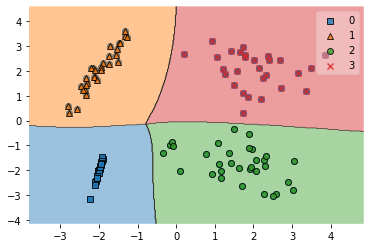

In [64]:
train_data(6)

Train on 640 samples
Epoch 1/40
640/640 [==============================] - 0s 568us/sample - loss: 1.3971 - accuracy: 0.1844
Epoch 2/40
640/640 [==============================] - 0s 91us/sample - loss: 1.3932 - accuracy: 0.1953
Epoch 3/40
640/640 [==============================] - 0s 85us/sample - loss: 1.3901 - accuracy: 0.2172
Epoch 4/40
640/640 [==============================] - 0s 86us/sample - loss: 1.3876 - accuracy: 0.1828
Epoch 5/40
640/640 [==============================] - 0s 83us/sample - loss: 1.3854 - accuracy: 0.1891
Epoch 6/40
640/640 [==============================] - 0s 86us/sample - loss: 1.3841 - accuracy: 0.2156
Epoch 7/40
640/640 [==============================] - 0s 87us/sample - loss: 1.3829 - accuracy: 0.2453
Epoch 8/40
640/640 [==============================] - 0s 86us/sample - loss: 1.3818 - accuracy: 0.2047
Epoch 9/40
640/640 [==============================] - 0s 84us/sample - loss: 1.3808 - accuracy: 0.2484
Epoch 10/40
640/640 [==============================

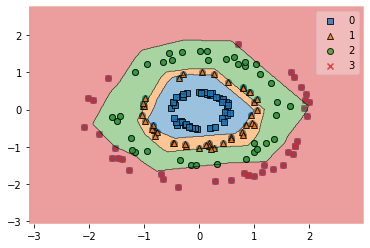

In [65]:
train_data(7)